In [1]:
import os
# Display current working directory
print(os.getcwd())
# To make sure opencv imports .exr files
os.environ["OPENCV_IO_ENABLE_OPENEXR"] = "1"
# If the current directory is not WDSS, then set it to one level up
if os.getcwd()[-4:] != 'WDSS':
    os.chdir('..')
print(os.getcwd())

c:\Dev\MinorProject\WDSS\jupyter_notebooks
c:\Dev\MinorProject\WDSS


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import cv2
import matplotlib.pyplot as plt
import time

from typing import List, Tuple, Dict

from config import device, Settings

In [5]:
from network.dataset import *

train_dataset = WDSSDatasetCompressed(Settings.dataset_path, 119, 128, 2)
train_dataset_no_patch = WDSSDatasetCompressed(Settings.dataset_path, 119, upscale_factor=2)
test_dataset = WDSSDatasetCompressed(Settings.test_dataset_path, frames_per_zip=119, upscale_factor=2)

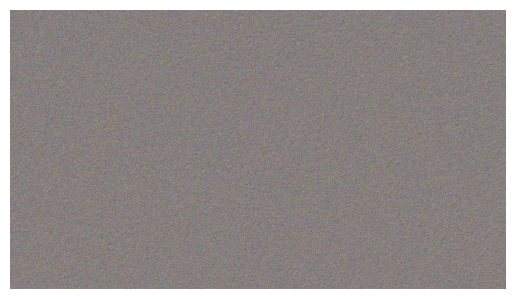

In [6]:
from network.modules import *

class WDSSModelV5(nn.Module):
    def __init__(self):
        super(WDSSModelV5, self).__init__()

        self.lr_frame_feature_extractor = LRFrameFeatureExtractor(12, 64, [32, 48, 48])
        self.hr_gbuffer_feature_extractor = HRGBufferFeatureExtractor(40, 5, 64)
        self.feature_fusion = FeatureFusion(64, 12, [64, 48])
        self.inr = FourierMappedINR(lr_feat_c=32, gb_feat_c=32, out_channels=12, mlp_inp_channels=64, hidden_channels=[64, 64, 64])

        self.final_conv = nn.Conv2d(12, 12, 3, 1, 1)

    def forward(self, lr_frame: torch.Tensor, hr_gbuffer: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        # Pixel unshuffling
        lr_frame_pixel_unshuffled = F.pixel_unshuffle(lr_frame, 2)
        hr_gbuffers_pixel_unshuffled = F.pixel_unshuffle(hr_gbuffer, 2)

        # Extract features
        lr_frame_feature = self.lr_frame_feature_extractor(lr_frame_pixel_unshuffled)
        hr_gbuffer_feature = self.hr_gbuffer_feature_extractor(hr_gbuffers_pixel_unshuffled)

        # Split the lr_frame_feature and hr_gbuffer_feature into 2-2 parts
        lr_frame_ff, lr_frame_inr = torch.split(lr_frame_feature, 32, dim=1)
        hr_gbuffer_ff, hr_gbuffer_inr = torch.split(hr_gbuffer_feature, 32, dim=1)

        # Upsample the lr_frame_ff
        lr_frame_ff = ImageUtils.upsample(lr_frame_ff, 2)

        # Feature Fusion, input is concatenated lr_frame_ff and hr_gbuffer_ff
        feature_fusion = self.feature_fusion(torch.cat([lr_frame_ff, hr_gbuffer_ff], dim=1))

        # INR
        inr = self.inr(lr_frame_inr, hr_gbuffer_inr)

        # Element-wise addition
        out = feature_fusion + inr

        # Final Convolution
        out = self.final_conv(out)

        return out, WaveletProcessor.batch_iwt(out)
    
# Model
model = WDSSModelV5().to(device)

# Run a forward pass to res
model.eval()
with torch.no_grad():
    test_data = test_dataset[1]
    lr_frame = test_data['LR'].unsqueeze(0).to(device)
    hr_gbuffer = test_data['GB'].unsqueeze(0).to(device)

    wavelets, res = model(lr_frame, hr_gbuffer)

    ImageUtils.display_image(res.detach().cpu())

In [7]:
from network.losses import CriteronMSE_SSIM

criteron = CriteronMSE_SSIM(0.8, 12)
learning_rate = 0.001

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


c:\Dev\MinorProject\WDSS\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Dev\MinorProject\WDSS\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Dev\MinorProject\WDSS\.venv\Lib\site-packages\lpips\weights\v0.1\vgg.pth


c:\Dev\MinorProject\WDSS\.venv\Lib\site-packages\lpips\lpips.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(model_path, map_location='

In [8]:
# Optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [9]:
# Data Loader
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [10]:
# Training variables
import threading

total_epochs: int = 0
epoch_loss: float = 0.0

In [11]:
# Training loop
epochs = 10

def do_nothing():
    pass

def train(i, batch):
    global total_epochs, epoch_loss

    lr_frame = batch['LR'].to(device)
    hr_gbuffer = batch['GB'].to(device)
    hr_frame = batch['HR'].to(device)

    optimizer.zero_grad()

    wavelet, img = model.forward(lr_frame, hr_gbuffer)
    hr_wavelet = WaveletProcessor.batch_wt(hr_frame)

    loss = criteron.forward(wavelet, hr_wavelet)

    loss.backward()
    optimizer.step()

    epoch_loss += loss.item()
    print(f'Batch {i} Loss: {loss.item()}')

threadu = threading.Thread(target=do_nothing)
threadu.start()

for epoch in range(epochs):
    epoch_loss = 0.0

    for i, batch in enumerate(train_loader):
        if threadu.is_alive():
            threadu.join()

        threadu = threading.Thread(target=train, args=(i, batch))
        threadu.start()
    
    if threadu.is_alive():
        threadu.join()

    total_epochs += 1
    print(f'Epoch {total_epochs} Loss: {epoch_loss}')

    # Save the model
    torch.save(model.state_dict(), 'model/v5/epoch_{total_epochs}_time_{time.time()}.pth')

KeyboardInterrupt: 

In [ ]:
# Save the model
torch.save(model.state_dict(), 'model/v5/epoch_{total_epochs}_time_{time.time()}.pth')

Model: MSE: 0.11202376335859299, SSIM: 0.002369722118601203, PSNR: 11.324811935424805, LPIPS: 0.8594996929168701
Bilinear: MSE: 0.0001408224052283913, SSIM: 0.9482903480529785, PSNR: 29.931480407714844, LPIPS: 0.23924541473388672


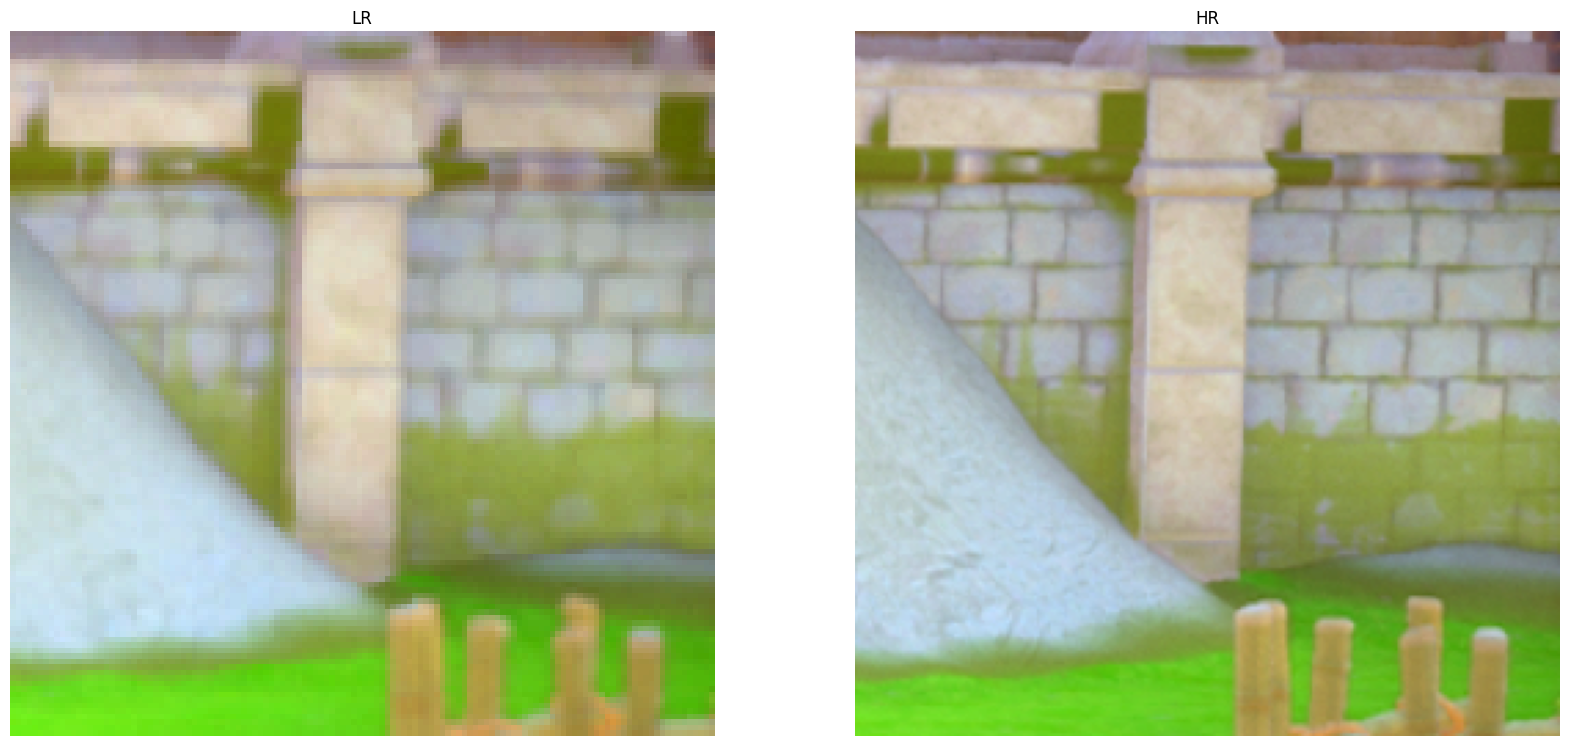

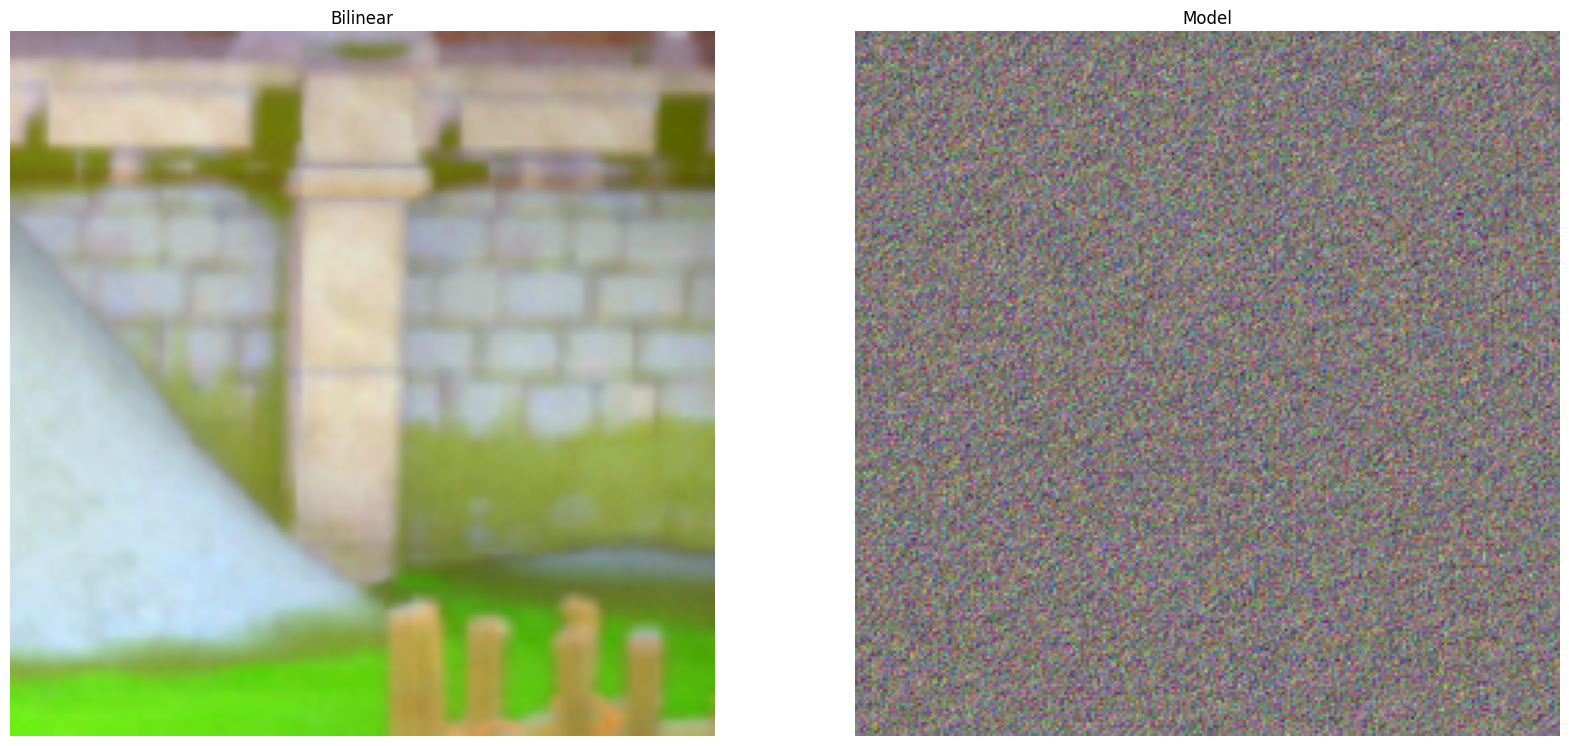

In [13]:
# Visualize the model output and score on one image
from network.losses import ImageEvaluator

def test(dataset: WDSSDatasetCompressed, frame_no: int):
    frame = dataset[frame_no]
    lr_frame = frame['LR'].unsqueeze(0).to(device)
    hr_gbuffer = frame['GB'].unsqueeze(0).to(device)
    hr_frame = frame['HR'].unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        wavelet, img = model(lr_frame, hr_gbuffer)

    # Bilinear upsample the lr_frame
    lr_frame_upsampled = ImageUtils.upsample(lr_frame, 2)

    # Compute losses
    mse_model = ImageEvaluator.mse(img, hr_frame)
    ssim_model = ImageEvaluator.ssim(img, hr_frame)
    psnr_model = ImageEvaluator.psnr(img, hr_frame)
    lpips_model = ImageEvaluator.lpips(img, hr_frame)

    mse_bilinear = ImageEvaluator.mse(lr_frame_upsampled, hr_frame)
    ssim_bilinear = ImageEvaluator.ssim(lr_frame_upsampled, hr_frame)
    psnr_bilinear = ImageEvaluator.psnr(lr_frame_upsampled, hr_frame)
    lpips_bilinear = ImageEvaluator.lpips(lr_frame_upsampled, hr_frame)

    print(f'Model: MSE: {mse_model}, SSIM: {ssim_model}, PSNR: {psnr_model}, LPIPS: {lpips_model.item()}')
    print(f'Bilinear: MSE: {mse_bilinear}, SSIM: {ssim_bilinear}, PSNR: {psnr_bilinear}, LPIPS: {lpips_bilinear.item()}')

    # Display the images
    ImageUtils.display_images([lr_frame.cpu(), hr_frame.cpu()], ['LR', 'HR'])
    ImageUtils.display_images([lr_frame_upsampled.cpu(), img.cpu()], ['Bilinear', 'Model'], normalize=True)

test(train_dataset, 5)